In [1]:
%matplotlib inline
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import ot

# load the data
samples_old = np.loadtxt("control.txt")
samples_new = np.loadtxt("new.txt")

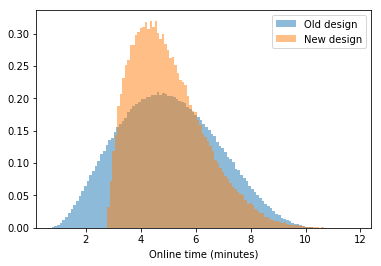

In [2]:
plt.hist(samples_old, bins=100, alpha=0.5, normed=True)
plt.hist(samples_new, bins=100, alpha=0.5, normed=True)
plt.legend(["Old design", "New design"])
plt.xlabel("Online time (minutes)")

In [3]:
nbins = 100
yhist_old, xhist_old = np.histogram(samples_old, bins=nbins)
yhist_new, xhist_new = np.histogram(samples_new, bins=nbins)

# normalization
yhist_old = yhist_old * 1.0 / np.sum(yhist_old)
yhist_new = yhist_new * 1.0 / np.sum(yhist_new)

# get the centre of the bins
xhist_old = (xhist_old[1:] + xhist_old[:-1]) / 2.0
xhist_new = (xhist_new[1:] + xhist_new[:-1]) / 2.0

In [4]:
# get the distance matrix
M = cdist(xhist_old[:,None], xhist_new[:,None], "sqeuclidean")

# compute the transport matrix
T = ot.emd(yhist_old, yhist_new, M)

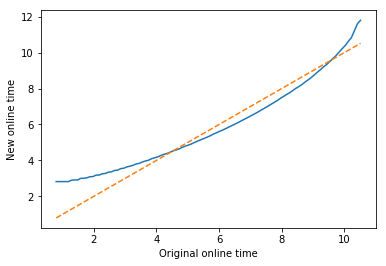

In [5]:
Tnorm = T / np.sum(T,axis=1)[:,None] # row normalization
xt = np.matmul(Tnorm, xhist_new[:,None]).flatten()
plt.plot(xhist_old, xt)
plt.plot(xhist_old, xhist_old, '--')
plt.xlabel("Original online time")
plt.ylabel("New online time")

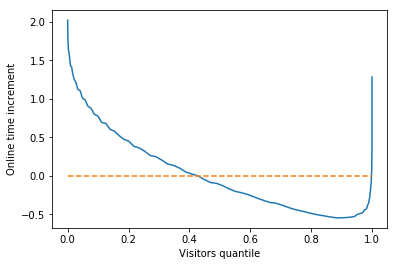

In [6]:
qtile = np.cumsum(yhist_old)
displacement = xt - xhist_old
plt.plot(qtile, displacement)
plt.plot(qtile, np.zeros_like(qtile), '--')
plt.xlabel("Visitors quantile")
plt.ylabel("Online time increment")

## Uncertainty

In [7]:
reg = 0.5 # regularization factor
Treg = ot.sinkhorn(yhist_old, yhist_new, M, reg)

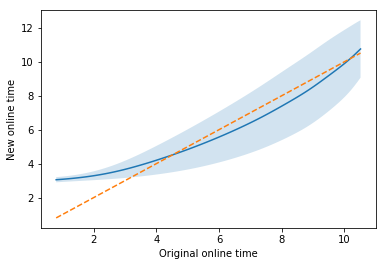

In [12]:
Treg_norm = Treg / np.sum(Treg, axis=1)[:,None]
xreg_t_mean = np.matmul(Treg_norm, xhist_new[:,None]).flatten()
xreg_t_var = np.matmul(Treg_norm, (xhist_new-xreg_t_mean)[:,None]** 2).flatten()
xreg_t_std = np.sqrt(xreg_t_var)

# plot
plt.plot(xhist_old, xreg_t_mean)
plt.fill_between(xhist_old, xreg_t_mean-xreg_t_std,
                 xreg_t_mean+xreg_t_std, alpha=0.2)
plt.plot(xhist_old, xhist_old, '--')
plt.xlabel("Original online time")
plt.ylabel("New online time")

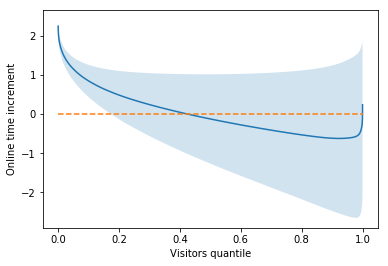

In [11]:
displacement_mean = xreg_t_mean - xhist_old
plt.plot(qtile, displacement_mean)
plt.fill_between(qtile, displacement_mean - xreg_t_std,
                 displacement_mean + xreg_t_std, alpha=0.2)
plt.plot(qtile, np.zeros_like(qtile), '--')
plt.xlabel("Visitors quantile")
plt.ylabel("Online time increment")